In [ ]:
import os
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import timm
import numpy as np

data_dir = 'paddy-disease-classification'
img_size = 224
batch_size = 32
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\USER\miniconda3\envs\paddy-viton\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
train_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

test_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

In [ ]:
full_dataset = ImageFolder(data_dir, transform=train_transforms)
class_names = full_dataset.classes
num_classes = len(class_names)

total_size = len(full_dataset)
val_size = test_size = int(0.1 * total_size)
train_size = total_size - val_size - test_size
generator=torch.Generator().manual_seed(42)

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size],generator=generator)
torch.save(test_dataset.indices, "test_indices.pth")

val_dataset.dataset.transform = test_transforms
test_dataset.dataset.transform = test_transforms

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
model = timm.create_model('vit_base_patch16_224.dino', pretrained=True).to(device)
with torch.no_grad():
    dummy_input = torch.randn(1, 3, img_size, img_size).to(device)
    features = model.forward_features(dummy_input)
    embedding_dim = features.shape[-1]

model.head = nn.Linear(embedding_dim, num_classes).to(device)


In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [ ]:
def train_one_epoch(model, loader):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return total_loss / total, correct / total

In [ ]:
def evaluate(model, loader):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return total_loss / total, correct / total

In [ ]:
best_val_acc = 0.0
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader)
    val_loss, val_acc = evaluate(model, val_loader)
    scheduler.step()
    print(f"Epoch {epoch} - Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_vit_dino.pth")


Epoch 1 - Train Loss: 1.0137, Acc: 0.8304 | Val Loss: 0.6989, Acc: 0.9661
Epoch 2 - Train Loss: 0.6137, Acc: 0.9863 | Val Loss: 0.6403, Acc: 0.9803
Epoch 3 - Train Loss: 0.5698, Acc: 0.9961 | Val Loss: 0.6193, Acc: 0.9821
Epoch 4 - Train Loss: 0.5551, Acc: 0.9986 | Val Loss: 0.6115, Acc: 0.9846
Epoch 5 - Train Loss: 0.5475, Acc: 0.9995 | Val Loss: 0.6111, Acc: 0.9864
Epoch 6 - Train Loss: 0.5474, Acc: 0.9987 | Val Loss: 0.6148, Acc: 0.9846
Epoch 7 - Train Loss: 0.5465, Acc: 0.9989 | Val Loss: 0.6107, Acc: 0.9821
Epoch 8 - Train Loss: 0.5439, Acc: 0.9995 | Val Loss: 0.6026, Acc: 0.9864
Epoch 9 - Train Loss: 0.5418, Acc: 0.9998 | Val Loss: 0.6019, Acc: 0.9858
Epoch 10 - Train Loss: 0.5405, Acc: 0.9998 | Val Loss: 0.6052, Acc: 0.9846
Epoch 11 - Train Loss: 0.5406, Acc: 0.9998 | Val Loss: 0.6091, Acc: 0.9815
Epoch 12 - Train Loss: 0.5403, Acc: 0.9997 | Val Loss: 0.6026, Acc: 0.9840
Epoch 13 - Train Loss: 0.5390, Acc: 0.9999 | Val Loss: 0.6026, Acc: 0.9840
Epoch 14 - Train Loss: 0.5385, Acc

In [ ]:
model.load_state_dict(torch.load("best_vit_dino.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

C:\Users\USER\AppData\Local\Temp\ipykernel_17252\696977735.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_vit_dino.pth"))



Classification Report:
                          precision    recall  f1-score   support

   bacterial_leaf_blight       0.98      0.93      0.96        60
   bacterial_leaf_streak       1.00      0.98      0.99        45
bacterial_panicle_blight       1.00      1.00      1.00        52
        black_stem_borer       0.98      0.94      0.96        53
                   blast       0.99      0.97      0.98       232
              brown_spot       1.00      1.00      1.00       117
            downy_mildew       0.93      0.96      0.94        77
                   hispa       0.97      1.00      0.98       222
             leaf_roller       0.98      0.97      0.98       111
                  normal       0.99      1.00      0.99       246
                  tungro       0.98      0.99      0.98       195
        white_stem_borer       0.98      0.99      0.98       127
       yellow_stem_borer       1.00      1.00      1.00        85

                accuracy                          

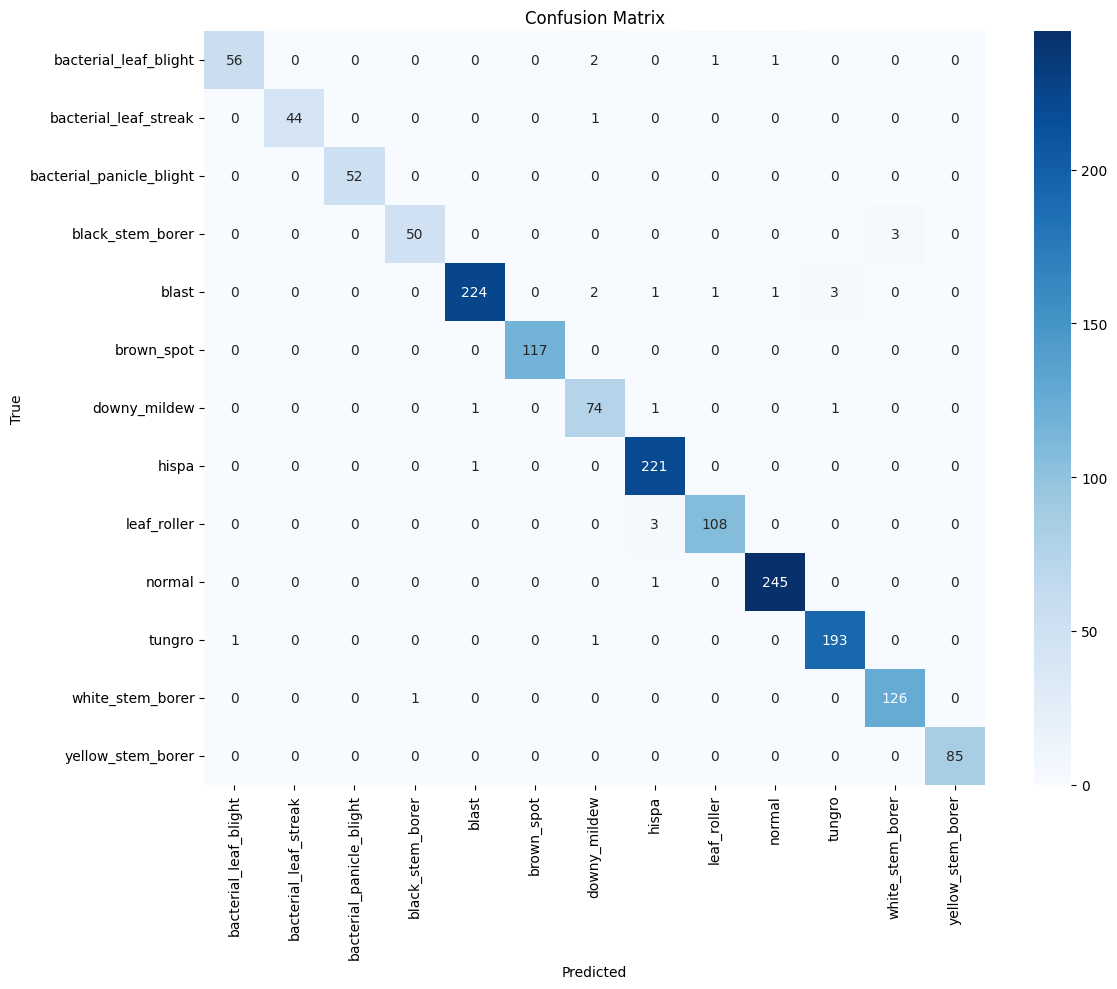

In [ ]:
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()
